<a href="https://colab.research.google.com/github/Kkuntal990/CTW_2020/blob/master/Copy_of_TRRS_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import h5py
f = h5py.File("/content/drive/My Drive/CTW_2019/h_Estimated_CTW_Train.h5")
H = f['h_Estimated'][:].T
f.close()
f = h5py.File("/content/drive/My Drive/CTW_2019/r_Position_CTW_Train.h5")
pos = f["r_Position"][:].T
f.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """


In [3]:
import numpy as np
X_pred = np.sqrt(H[:,:,:,0]**2 + H[:,:,:,1]**2)

In [4]:
from pickle import load
pca = load(open("/content/drive/My Drive/CTW_2019/PCA_Unsupervised.sav" , "rb"))

In [5]:
from tensorflow.keras.models import Model,Sequential , load_model
best = load_model("/content/drive/My Drive/CTW_2019/Best_PCA_CNN.h5")

In [6]:
from sklearn.model_selection import train_test_split
X_pred = X_pred.reshape(-1,924)
from sklearn.decomposition import PCA
X_pred = pca.transform(X_pred)
X_pred = X_pred.reshape(-1 , 16,66)
X_pred = X_pred.reshape(X_pred.shape[0],-1,1)
pos_cnn = best.predict(X_pred)
del X_pred
pos_cnn , pos_cnn_test = train_test_split(pos_cnn, test_size=0.1, random_state=54)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(H, pos, test_size=0.1, random_state=54)
del H, pos_cnn

In [8]:
import numpy as np
class TRRS:
  def __init__(self, CFR , CFR_Pos):
    self.CFR = CFR
    self.CFR_Pos = CFR_Pos
  
  def get_fingerprint_subset(self , pos , radius = 1):
    self.pos2 = pos
    out = []
    for i in range(len(self.CFR_Pos)):
      if np.sqrt(np.sum((pos-self.CFR_Pos[i])**2)) < radius:
        out.append(i)
    return np.array(out)

  def predict(self , H2 , Pos2=[] , radius=1):
      if len(Pos2)==0:
        idx = range(len(self.CFR))
      else:
        idx = self.get_fingerprint_subset(Pos2 , radius)
      idx = idx.astype('int')
      H1 = self.CFR[idx]
      pos = self.CFR_Pos[idx]
      print(H1.shape)
      Yd1 = np.sum((H1*H1)[:,:,:,0] + (H1*H1)[:,:,:,1] , axis=2)
      Yd2 = np.sum((H2*H2)[:,:,0] + (H2*H2)[:,:,1] , axis=1)
      #print((Yd1*Yd2).shape)

      H11 = H1[:,:,:,0] + H1[:,:,:,1] * 1j
      H22 = H2[:,:,0] - H2[:,:,1] * 1j
      G = H11 * H22
      #print(G.shape)
      Nser = 1024
      Nu = 924
      G = np.concatenate((G, np.zeros((H1.shape[0],16,Nser-Nu))), axis=2)
      #print(G.shape)

      g = np.fft.fftn(G, axes=(2,))
      #print(g.shape)

      phi_d = np.ndarray.max((np.square(np.abs(g))), axis=2)
      phi_d = np.divide(phi_d,(Yd1*Yd2))
      #print(phi_d.shape)

      w_d = np.sqrt((Yd1 * Yd2))
      w_d = np.transpose(w_d)/(np.sqrt(np.sum(Yd1, axis=1)) * np.sum(Yd2))
      w_d = np.transpose(w_d)
      #print(w_d.shape)
      
      TRRS = np.sum(np.multiply(w_d,np.sqrt(phi_d)), axis=1)
      TRRS = np.square(TRRS)
      #print(TRRS)

      
      try:
        idx = np.argmax(TRRS)
      except:
        return self.pos2

      return pos[idx,:]


  def batch_predict(self , H2 , Pos2=[] , radius=1)
    batch_size = H2.shape[0]
    out_pos = []
    for i in range(batch_size):
      out_pos.append(self.predict(H2[i], Pos2[i],radius=1)
    return out_pos
  

In [9]:
trrs = TRRS(X_train, y_train)

print(trrs.predict(X_test[2], pos_cnn_test[2], radius=0.3))
print(y_test[2])

(801, 16, 924, 2)
[ 3.7009  0.9313 -0.5238]
[ 3.7009  0.9313 -0.5238]


In [10]:
def rmse(y1,y2):
  return np.sqrt(np.sum((y1-y2)**2))

In [11]:
import time
errors = []
starttime = time.time()
for i in range(len(X_test)):
  y1 = trrs.predict(X_test[i], pos_cnn_test[i], radius=0.30)
  y2 = y_test[i]
  errors.append(rmse(y1,y2))
  print(errors[i])

  if((i+1)%50==0):
    endtime = time.time()
    print("At i = " , i+1 , "Time :" , endtime-starttime)
    starttime = time.time()

(627, 16, 924, 2)
0.0
(829, 16, 924, 2)
0.02972019515413698
(801, 16, 924, 2)
0.0
(525, 16, 924, 2)
0.2909829032778386
(716, 16, 924, 2)
0.321004890928472
(593, 16, 924, 2)
0.0
(514, 16, 924, 2)
0.0
(153, 16, 924, 2)
0.0
(469, 16, 924, 2)
0.0
(628, 16, 924, 2)
0.0
(940, 16, 924, 2)
0.07794459570746398
(659, 16, 924, 2)
0.0
(388, 16, 924, 2)
0.0
(616, 16, 924, 2)
0.0
(422, 16, 924, 2)
0.0
(358, 16, 924, 2)
0.0
(633, 16, 924, 2)
0.0
(461, 16, 924, 2)
0.0
(763, 16, 924, 2)
0.0
(687, 16, 924, 2)
0.0
(471, 16, 924, 2)
0.0
(608, 16, 924, 2)
0.0
(993, 16, 924, 2)
0.0
(717, 16, 924, 2)
0.012031209415515838
(436, 16, 924, 2)
0.017756407294269666
(603, 16, 924, 2)
0.0004472135954999087
(383, 16, 924, 2)
0.0
(553, 16, 924, 2)
0.0
(641, 16, 924, 2)
0.0
(811, 16, 924, 2)
0.0
(656, 16, 924, 2)
0.0
(1047, 16, 924, 2)
0.0
(187, 16, 924, 2)
0.0
(685, 16, 924, 2)
0.0
(457, 16, 924, 2)
0.0
(1251, 16, 924, 2)
0.0
(521, 16, 924, 2)
0.00044721359550010725
(280, 16, 924, 2)
0.0
(780, 16, 924, 2)
0.0
(839, 16

0.019800707901215464
[0.001, 0.02972019515413698, 0.001, 0.2909829032778386, 0.321004890928472, 0.001, 0.001, 0.001, 0.001, 0.001, 0.07794459570746398, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.012031209415515838, 0.017756407294269666, 0.0004472135954999087, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.00044721359550010725, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.01827949671079602, 0.6401369072315701, 0.0013076696830623042, 0.04286735354555967, 0.001, 0.001, 0.00037416573867735293, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.6274198116094197, 0.004302324952859538, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.020516091245653945, 0.001, 0.001, 0.0010630145812737656, 0.001, 0.001, 0.06451852447165862, 0.001, 0.001, 0.001, 0.001, 0.020300985197767754, 0.001, 0.001, 0.001, 0.001, 0.001, 0.25045241064920903, 0.001, 0.001, 0.001, 0.016169415573854252,

(array([  16.,    5., 1459.,   12.,   35.,   61.,   65.,   50.,   37.,
           9.]),
 array([-9.21034037, -8.24331528, -7.27629019, -6.3092651 , -5.34224   ,
        -4.37521491, -3.40818982, -2.44116473, -1.47413964, -0.50711455,
         0.45991055]),
 <a list of 10 Patch objects>)

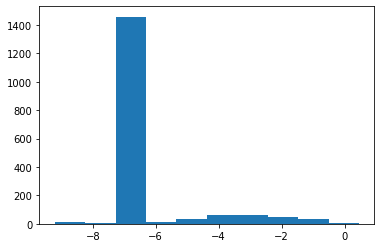

In [20]:
print(np.mean(errors))
import matplotlib.pyplot as plt
for i in range(len(errors)):
  if(errors[i]==0):
    errors[i] = 0.00000001
print(errors)
plt.hist(np.log(errors))

In [21]:
import keras

best.trainable = False
from keras.optimizers import Adadelta, Adam, RMSprop, SGD
best.compile(optimizer='Adam', loss = 'mean_squared_error')
best.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1054, 16)          64        
_________________________________________________________________
flatten (Flatten)            (None, 16864)             0         
_________________________________________________________________
dropout (Dropout)            (None, 16864)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              17269760  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3

In [25]:
trrs = TRRS(X_train, y_train)

def ensemble():
  inputA = keras.layers.Input(shape=(16,))
  inputB = keras.layers.Input(shape=(16,924,2))

  comp = pca.transform(inputB.keras.layers.Reshape(-1,924))
  comp = comp.keras.layers.Reshape(-1,16,66)
  comp = comp.keras.layers.Reshape(comp.shape[0],-1,1)
  nn_out = best(inputs=comp)
  trrs_out = trrs.batch_predict(inputB,nn_out,radius=0.3)

  comb = concatenate([nn_out,trrs_out, inputB])
  x = keras.layers.Dropout(0.3)(comb)
  x = Dense(64, activation = 'tanh', kernel_initializer='glorot_uniform')(x)
  x = Dense(64, activation = 'tanh', kernel_initializer='glorot_uniform')(x)
  x = Dense(64, activation = 'tanh', kernel_initializer='glorot_uniform')(x)
  out = Dense(3,activation='tanh')
  return Model(inputs=[inputA, inputB], outputs=out)


pre_final = ensemble()
print(final.summary())


AttributeError: ignored

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

pre_final.compile(optimizer = 'Adam', loss='mean_squared_error')
earlystopper = EarlyStopping(patience = 20, verbose=1)
checkpointer = ModelCheckpoint('/content/drive/My Drive/CTW_2019/ensemble_pre_final.h5', verbose=1, save_best_only=True)
pre_final.fit([X_train, SNR_train], y_train, epochs = 150, verbose=1, batch_size = 40, validation_split=0.15, callbacks = [checkpointer, earlystopper])